# Basic arithmetic with the quantum Fourier transform (QFT)
[Demo](https://pennylane.ai/qml/demos/tutorial_qft_arithmetics.html)

Useful resources:
* [Xanadu Codebook F](https://codebook.xanadu.ai/F.1)
* [Qiskit Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)


Arithmetic is a fundamental branch of mathematics that consists of the study of the main operations with numbers such as addition, multiplication, subtraction and division. Using arithmetic operations we can understand the world around us and solve many of our daily tasks.

Arithmetic is crucial for the implementation of any kind of algorithm in classical computer science, but also in quantum computing. For this reason, in this demo we are going to show an approach to defining arithmetic operations on quantum computers. The simplest and most direct way to achieve this goal is to use the quantum Fourier transform (QFT), which we will demonstrate on a basic level.

In this demo we will not focus on understanding how the QFT is built, as we can find a great explanation in the Xanadu Quantum Codebook. Instead, we will develop the intuition for how it works and how we can best take advantage of it.

## Motivation

The first question we have to ask ourselves is whether it makes sense to perform these basic operations on a quantum computer. Is the goal purely academic or is it really something that is needed in certain algorithms? Why implement in a quantum computer something that we can do with a calculator?

When it comes to basic quantum computing algorithms like the Deustch–Jozsa or Grover’s algorithm, we might think that we have never needed to apply any arithmetic operations such as addition or multiplication. However, the reality is different. When we learn about these algorithms from an academic point of view, we work with a ready-made operator that we never have to worry about, the oracle. Unfortunately, in real-world situations, we will have to build this seemingly magical operator by hand. As an example, let’s imagine that we want to use Grover’s algorithm to search for magic squares. To define the oracle, which determines whether a solution is valid or not, we must perform sums over the rows and columns to check that they all have the same value. Therefore, to create this oracle, we will need to define a sum operator within the quantum computer.

The second question we face is why we should work with the QFT at all. There are other procedures that could be used to perform these basic operations; for example, by imitating the classical algorithm. But, as we can see in [(1)](https://arxiv.org/abs/quant-ph/0008033), it has already been proven that the QFT needs fewer qubits to perform these operations, which is nowadays of vital importance.

We will organize the demo as follows. Initially, we will talk about the Fourier basis to give an intuitive idea of how it works, after which we will address different basic arithmetic operations. Finally, we will move on to a practical example in which we will factor numbers using Grover’s algorithm.

## QFT representation

To apply the QFT to basic arithmetic operations, our objective now is to learn how to add, subtract and multiply numbers using quantum devices. As we are working with qubits, —which, like bits, can take the values 0 or 1 — we will represent the numbers in binary. For the purposes of this tutorial, we will assume that we are working only with integers. Therefore, if we have n
 qubits, we will be able to represent the numbers from 0
 to $2^n-1$.
 The first thing we need to know is PennyLane’s standard for encoding numbers in a binary format. A binary number can be represented as a string of 1s and 0s, which we can represent as the multi-qubit state
 $$\Ket{m} = \Ket{\overline{q_0q_1...q_{n-1}}}$$
 where the formula to obtain the equivalent decimal number $m$ will be:
 $$m = \sum_{i=0}^{n-1} 2^{n-1-i}q_i$$
 Note that $\Ket{m}$ refers to the basic state generated by the binary encoding of the number $m$. For instance, the natural number $6$ is represented by quantum state $\Ket{110}$, since $\Ket{110} = 1*2^2 + 1*2^1 + 0*2^0 = 6$.

In [4]:
import numpy as np
k_bits = 3
for index in range(2**k_bits):
    ctrl_str = np.binary_repr(index, k_bits) # Create binary representation
    print(index," ", ctrl_str)

0   000
1   001
2   010
3   011
4   100
5   101
6   110
7   111


<img src="./images/3_qubits_computational_basis.gif" width="630">

We can use the [qml.BasisEmbedding](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html#pennylane.BasisEmbedding) template to obtain the binary representation in a simple way. Let's see how we would code the number 6.

In [5]:
import pennylane as qml
import matplotlib.pyplot as plt

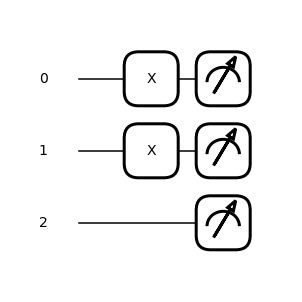

In [8]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
@qml.compile()
def basis_embedding_circuit(m):
    qml.BasisEmbedding(m, wires=range(3))
    return qml.state()

m = 6 #number to be encoded

qml.draw_mpl(basis_embedding_circuit,show_all_wires=True)(m)
plt.show()

As we can see, the first qubit-the 0-th wire - is placed on the top and the rest of the qubits are below it. However, this is not the only way we could represent numbers. We can also represent them in different bases, such as the so-called *Fourier base*.
<img src="./images/3_qubits_fourier_basis.gif" width="630">

As we can see,the third qubit will rotate $\frac{1}{8}$ of a turn counterclockwise with each number. The next qubit rotates $\frac{1}{4}$ of a full turn and, finally, the first qubit rotates half a turn for each increase in number.

## Adding a number to a register

The fact that the states encoding the numbers are now in phase gives us greate flexibility in carrying out our arithmetic operations. To see this in practice, let's look at the situation in which want to create an operator Sum such that:
$$Sum(k)\Ket{m} = \Ket{m+k}$$

The procedure to implement this unitary operation is the following:
1. We convert the state from the computational basis into the Fourier basis by applying the QFT to the $\Ket{m}$ state vio the [QFT](https://docs.pennylane.ai/en/stable/code/api/pennylane.QFT.html#pennylane.QFT) operator.
2. We rotate the $j$-th qubit by the angle $\frac{2k\pi}{2^j}$ using the $R_Z$ gate, which leads to the new phases, $\frac{2(m+k)\pi}{2^j}$.
3. We apply the QFT inverse to retun to the computational basis and obtain $m+k$.

Let's see how this process would look in PennyLane.

In [16]:
n_wires = 6
dev = qml.device("default.qubit", wires=n_wires, shots=1)

# Step 2 - rotate the j=th qubit by angle 2kpi/2^j
def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k*np.pi/(2**j), wires=wires[j])

@qml.qnode(dev)
def sum(m, k):
    #m encoding
    qml.BasisEmbedding(m, wires=range(n_wires))
    #step 1
    qml.QFT(wires=range(n_wires))
    #step 2
    add_k_fourier(k,range(n_wires))
    #step 3
    qml.adjoint(qml.QFT)(wires=range(n_wires))

    return qml.sample()

print(f"The ket representation of the sum of 3 and 4 is {sum(7,4)}")

The ket representation of the sum of 3 and 4 is [1 0 1 1]


Note that this is a deterministic algorithm, which means that we have obtained the desired solution by executing a single shot. On the other hand, if the result of an operation is greater than the maximum value $2^n -1$, we will start again from zero, that is to say, we will calculate the sum modulo $2^n -1$. For instance, in our three-qubit example, suppose that we want to calculate $6+3$. We see that we do not have enough memory space, as $6+3 = 9 > 2^3 -1$. The result we will get will be $9 (mod 8) = 1$ or $\Ket{001}$ in binary. Make sure to use enough qubits to represent your solutions! Finally, it is important to point out that it is not necessary to know how the QFT is constructed in order to use it. BY knowing the properties of the new basis, we can use it in a simple way.

## Adding two different registers

In the previous algorithm, we had to pass to the operator the value of $k$ that we wanted to add to the starting state. But at other times, instead of passing that value to the operator, we would like it to pull the information from another register. That is, we  are looking for a new operator $Sum_2$ such that
$$Sum_2 \Ket{m}\Ket{k}\Ket{0} = \Ket{m}\Ket{k}\Ket{m+k}$$
In this case, we can understand the third register (which is initially at 0) as a counter that will tally as many units as $m$ and $k$ combined. The binary decomposition will make this simple. If we have $\Ket{m} = \Ket{\overline{q_0q_1q_2}}$, we will have to add 1 to the counter if q_2 = 1 and nothing otherwise. In general, we should add $2^{n-i-1}$ units if the $i-th$ qubit is in state $\Ket{1}$ and 0 otherwise. As we can see, this is the same idea that is also behind the concept of a controlled gate. Indeed, observe that we will, indeed, apply a corresponding phase if indeed the control qubit is in the sate $\Ket{1}$. Let us now code the $Sum_2$ operator.

In [17]:
wires_m = [0,1,2] #qubits needed to encode m
wires_k = [3,4,5] # qubits needed to encode k
wires_solution = [6,7,8,9] # qubits needed to encode the solution

The ket representation of the sum 7 and 3 is [1 0 1 0] = 10


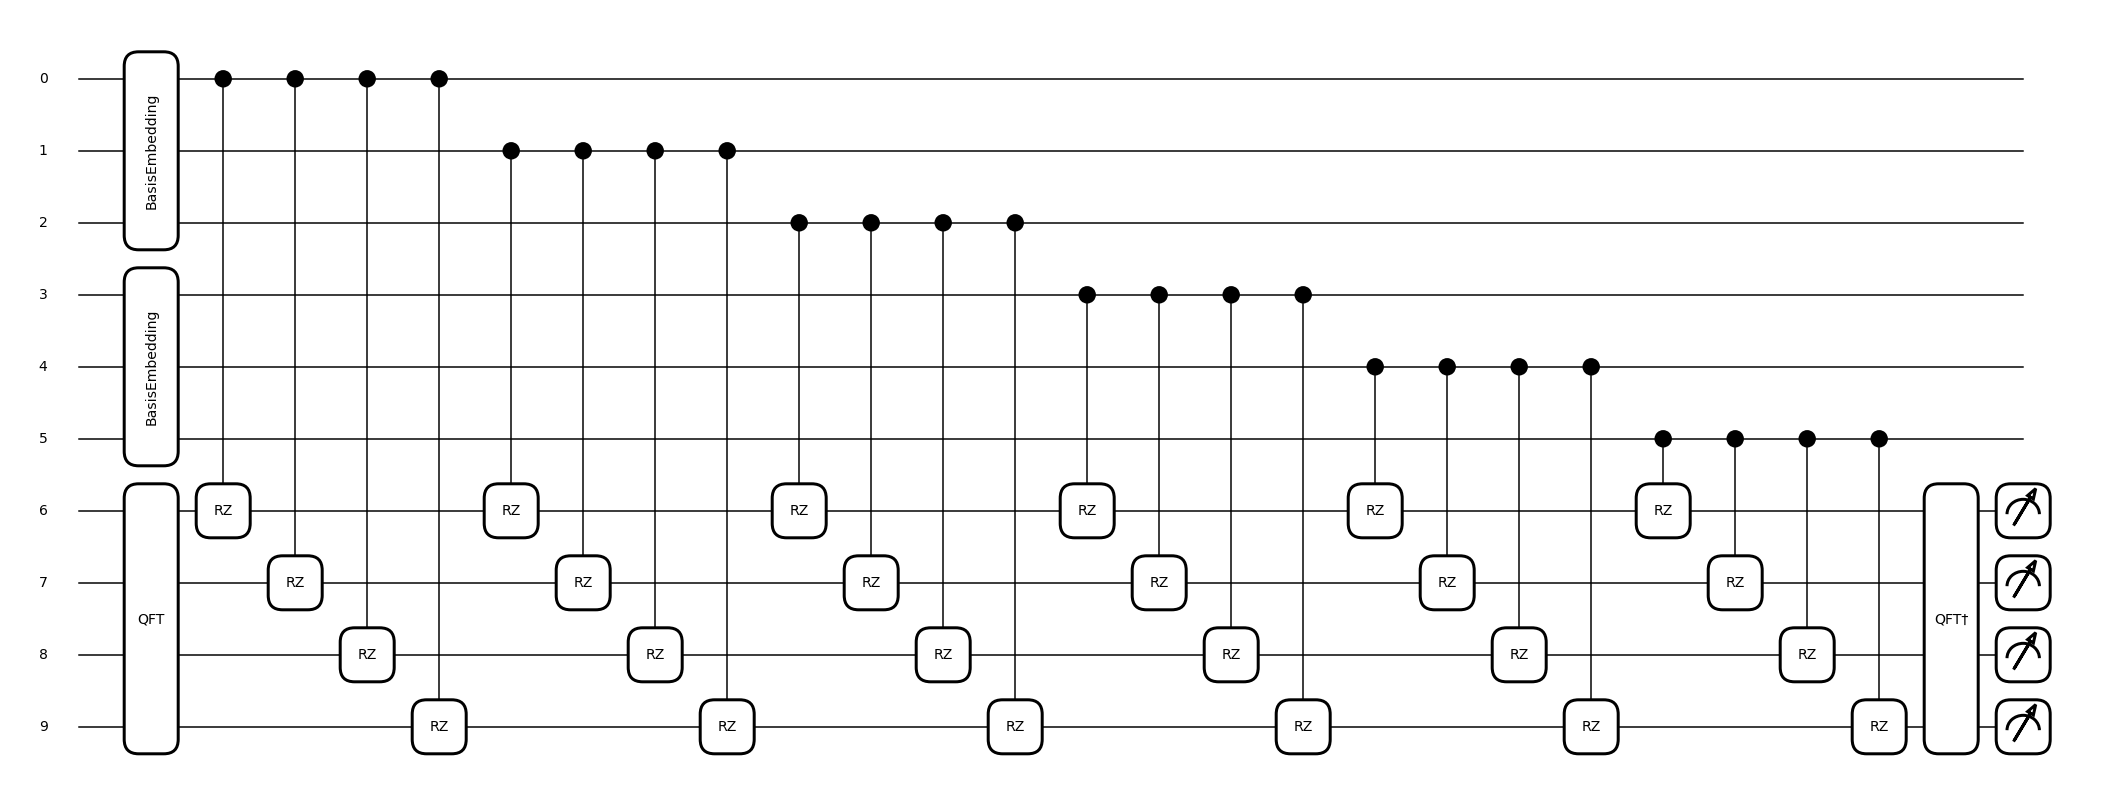

In [49]:
dev = qml.device("default.qubit", wires = wires_m + wires_k+wires_solution, shots = 1)

n_wires = len(dev.wires)

def addition(wires_m, wires_k, wires_solution):
    # prepare solution qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_m)):
        qml.ctrl(add_k_fourier, control=wires_m[i])(2**(len(wires_m)-i-1), wires_solution)

    # add k to the counter
    for i in range(len(wires_k)):
        qml.ctrl(add_k_fourier, control=wires_k[i])(2**(len(wires_k)-i-1), wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def sum2(m,k,wires_m, wires_k,wires_solution):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # apply the addition circuit
    addition(wires_m,wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

m = 7
k = 3
solution_binary = sum2(m,k,wires_m,wires_k,wires_solution).numpy()
solution= ''.join(str(x) for x in solution_binary)

print("The ket representation of the sum", m, "and",k, "is", solution_binary,"=",int(solution,2))

qml.draw_mpl(sum2,show_all_wires=True)(m, k, wires_m, wires_k, wires_solution)
plt.show()